In [36]:
import numpy as np
import glob
import re
import shutil
import random
import itertools
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
!pip install tensorflow_addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 14.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
def parser(example):
    feature = {
        'wave1':tf.io.FixedLenFeature([],tf.string),
        'wave2':tf.io.FixedLenFeature([],tf.string),
        'state':tf.io.FixedLenFeature([],tf.string),
        'diff':tf.io.FixedLenFeature([],tf.string),
    }
    feature = tf.io.parse_single_example(example,feature)

    wave1 = tf.io.parse_tensor(feature['wave1'],out_type = tf.float32)
    wave1 = tf.reshape(wave1,(1024,19))

    wave2 = tf.io.parse_tensor(feature['wave2'],out_type = tf.float32)
    wave2 = tf.reshape(wave2,(1024,19))

    state = tf.io.parse_tensor(feature['state'],out_type = tf.float32)
    state = tf.reshape(state,(2,))

    diff = tf.io.parse_tensor(feature['diff'],out_type = tf.float32)
    diff = tf.reshape(diff,(1,))

    
    return {'wave1':wave1,'wave2':wave2,'state':state},{'difference':diff}


In [65]:
batch_size = 32

In [66]:
def get_ds(ds):
    ds = tf.data.TFRecordDataset(ds,compression_type = "GZIP")
    ds = ds.map(parser,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    ds = ds.shuffle(buffer_size = 300)
    ds = ds.batch(batch_size,drop_remainder = True)
    ds = ds.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return ds

In [67]:
train_ds = get_ds("/content/drive/MyDrive/FewShot/train_rec")
test_ds = get_ds("/content/drive/MyDrive/FewShot/test_rec")
val_ds = get_ds("/content/drive/MyDrive/FewShot/val_rec")

In [68]:
train_ds

<_PrefetchDataset element_spec=({'wave1': TensorSpec(shape=(32, 1024, 19), dtype=tf.float32, name=None), 'wave2': TensorSpec(shape=(32, 1024, 19), dtype=tf.float32, name=None), 'state': TensorSpec(shape=(32, 2), dtype=tf.float32, name=None)}, {'difference': TensorSpec(shape=(32, 1), dtype=tf.float32, name=None)})>

In [201]:
class SQD(tf.keras.layers.Layer):
    def __init__(self):
        super(SQD, self).__init__()
    def call(self, inputs):
        x, y = inputs
        diff = tf.subtract(x, y)
        return tf.square(diff)
    

In [277]:
def wave_downsample():
    input = tf.keras.Input(batch_size = batch_size,shape = (1024,19))
    output = tf.keras.layers.LSTM(10,return_sequences = True)(input)
    output = tf.keras.layers.Dense(2)(output)
    output = tf.keras.layers.Flatten()(output)
    output = tf.keras.layers.Activation('relu')(output)
    output = tf.keras.layers.Dropout(0.3)(output)
    output = tf.keras.layers.Dense(20)(output)
    output = tf.keras.layers.Dropout(0.1)(output)
    model = tf.keras.Model(inputs = [input],outputs = [output])
    return model
     
def get_model():
    wave1 = tf.keras.Input(batch_size = batch_size,shape = (1024,19),name = 'wave1')
    wave2 = tf.keras.Input(batch_size = batch_size,shape = (1024,19),name = 'wave2')
    state = tf.keras.Input(batch_size = batch_size,shape = (2,),name = 'state')
    
    output1 = tf.keras.layers.BatchNormalization()(wave1)
    output2 = tf.keras.layers.BatchNormalization()(wave2)

    down_sampler = wave_downsample()
    output1 = down_sampler(output1)
    output2 = down_sampler(output2)

    output1 = tf.keras.layers.Activation('tanh')(output1)
    output1 = tf.keras.layers.Dropout(0.2)(output1)

    output2 = tf.keras.layers.Activation('tanh')(output2)
    output2 = tf.keras.layers.Dropout(0.2)(output2)

    output = SQD()([output1,output2])
    output = tf.keras.layers.concatenate([output,state])
    output = tf.keras.layers.Dense(10,kernel_regularizer = tf.keras.regularizers.L2(1e-5) )(output)
    output = tf.keras.layers.Dense(1,activation = 'sigmoid',name = 'difference',activity_regularizer = tf.keras.regularizers.L1(1e-5) )(output)
    
    model = tf.keras.Model(inputs = [wave1,wave2,state],outputs = [output],name = 'FewShot')
    return model

In [278]:
model = get_model()
model.summary()

Model: "FewShot"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 wave1 (InputLayer)             [(32, 1024, 19)]     0           []                               
                                                                                                  
 wave2 (InputLayer)             [(32, 1024, 19)]     0           []                               
                                                                                                  
 batch_normalization_100 (Batch  (32, 1024, 19)      76          ['wave1[0][0]']                  
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_101 (Batch  (32, 1024, 19)      76          ['wave2[0][0]']            

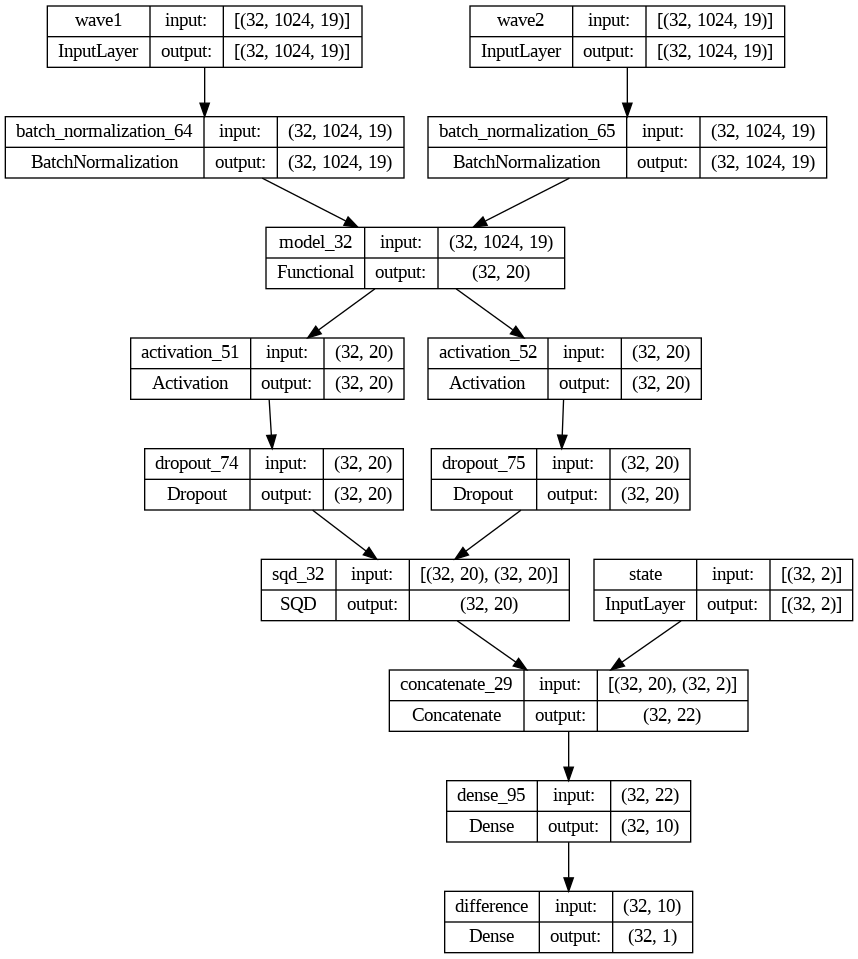

In [205]:
tf.keras.utils.plot_model(model,show_shapes = True,show_layer_names = True)

In [249]:
cbs = tf.keras.callbacks.ModelCheckpoint("weights/best_one",monitor = 'val_loss',save_best_only = True,save_weights_only = True)

In [279]:
model = get_model()

In [280]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics = [tfa.metrics.F1Score(num_classes = 1),'acc'])

In [281]:
model.fit(train_ds,epochs = 15,validation_data = val_ds,callbacks = [cbs])

Epoch 1/15
8/8 [==============================] - 7s 201ms/step - loss: 0.8704 - f1_score: 0.6838 - acc: 0.4531 - val_loss: 0.6887 - val_f1_score: 0.7071 - val_acc: 0.5781
Epoch 2/15
8/8 [==============================] - 1s 69ms/step - loss: 0.7645 - f1_score: 0.6838 - acc: 0.4727 - val_loss: 0.7043 - val_f1_score: 0.7071 - val_acc: 0.6094
Epoch 3/15
8/8 [==============================] - 1s 71ms/step - loss: 0.7182 - f1_score: 0.6701 - acc: 0.5508 - val_loss: 0.7097 - val_f1_score: 0.6939 - val_acc: 0.5625
Epoch 4/15
8/8 [==============================] - 1s 67ms/step - loss: 0.6527 - f1_score: 0.6804 - acc: 0.5859 - val_loss: 0.7080 - val_f1_score: 0.7200 - val_acc: 0.5625
Epoch 5/15
8/8 [==============================] - 1s 69ms/step - loss: 0.5725 - f1_score: 0.6939 - acc: 0.6914 - val_loss: 0.6959 - val_f1_score: 0.6939 - val_acc: 0.5625
Epoch 6/15
8/8 [==============================] - 1s 68ms/step - loss: 0.4640 - f1_score: 0.6770 - acc: 0.7422 - val_loss: 0.6675 - val_f1_score

In [283]:
model.load_weights("/content/weights/best_one")
model.evaluate(val_ds)

2/2 [==============================] - 0s 66ms/step - loss: 0.3850 - f1_score: 0.7071 - acc: 0.8125


[0.38503992557525635, array([0.7070707], dtype=float32), 0.8125]

In [285]:
shutil.make_archive("/content/final_weights","zip","/content/weights")

'/content/final_weights.zip'

In [286]:
shutil.move("/content/final_weights.zip","/content/drive/MyDrive/FewShot/")

'/content/drive/MyDrive/FewShot/final_weights.zip'